In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35803")
client

<Client: 'tcp://127.0.0.1:35803' processes=8 threads=32, memory=117.94 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
# from xhistogram.xarray import histogram as xhist
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
# import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
# plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [8]:
ds = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask()
ds

<xarray.Dataset>
Dimensions:        (time_counter: 2208, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009...
Dimensions without coordinates: x, y
Data variables:
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

In [13]:
eta = ds.sossheig.isel(time_counter=12)

In [24]:
u = -eta.diff('y') / ds.e2v.isel(y=slice(1,None)) / gsw.f(.5*(ds.lat.isel(y=slice(1,None))+ds.lat.isel(y=slice(None,-1))))
u

<xarray.DataArray (y: 762, x: 611)>
dask.array<truediv, shape=(762, 611), dtype=float64, chunksize=(762, 611), chunktype=numpy.ndarray>
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(762, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(762, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(762, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(762, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(762, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(762, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(762, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(762, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(762, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(762, 611), meta=np.ndarray>
    time_centered  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_counter   datetime64[ns] 2009-08-01T12:30:00
Dimensions without coordinates: y, x

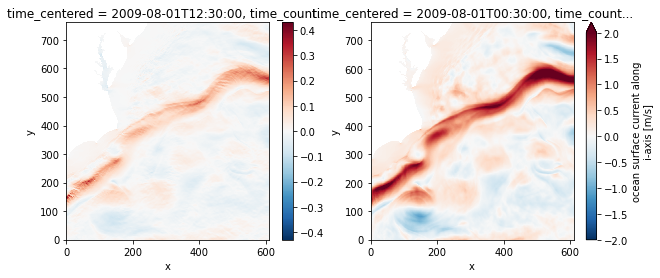

In [25]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
u.plot(ax=ax1)
ds.sozocrtx.isel(time_counter=0).plot(ax=ax2, vmax=2)

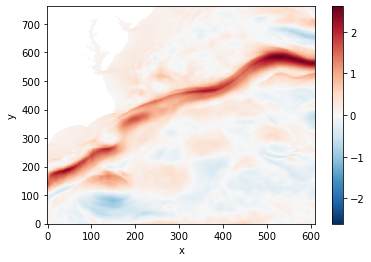

In [21]:
(.5*(ds.sozocrtx.isel(time_counter=0,y=slice(1,None))
     + ds.sozocrtx.isel(time_counter=0,y=slice(None,-1))
    ) - u).plot()